#Subclassing and Superclassing: Multimodal SoftMax

Our SoftMax class's `poly` attribute allows us to input a polygon, from which it automatically generates all the normal vectors and turns them into weights (following the process in [Chapter 2](02_from_templates.ipynb)). But, can we specify *any* polygon? 

As we've seen in the T-shape example, we need to ensure the sum of all the normals is zero. We fixed that by subdividing a class into multiple classes that ensure the sum of all normals is zero, but we manually subdivided the South class to do so. Is there an algorithm we can develop to subdivide our classes into subclasses that sum to zero, then recombine those subclasses into the original classes we wanted? Would we be asking that question if we didn't have an answer?

## Superclasses and Multimodal SoftMax

Two or more classes can be combined by associating them with the same label and summing their probabilities. This allows for non-convex classes (such as, say, a ring of probability density surrounding a center class). In the pentagon example from chapter 3, we could also describe the target's location as either inside or outside the pentagon, as such:

[ 2. -1.]


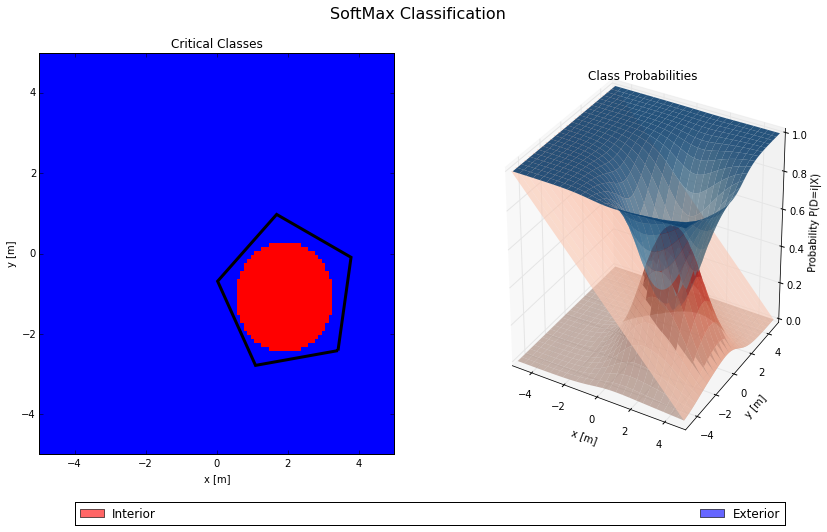

In [2]:
import numpy as np
from cops_and_robots.robo_tools.fusion.softmax import SoftMax, make_regular_2D_poly
%matplotlib inline


labels = ['Interior','Exterior','Exterior', 'Exterior', 'Exterior', 'Exterior']
poly = make_regular_2D_poly(5, max_r=2, theta=-np.pi/4, origin=(2,-1))
sm = SoftMax(poly=poly, class_labels=labels, resolution=0.1, steepness=3)
sm.plot(plot_poly=True, plot_normals=False)    

But, we have a problem: our class boundaries have shifted. What's going on here? Let's examine a 1D case. The first plot below shows a SoftMax distribution with three separate classes, whereas the second plot shows a Multimodal SoftMax distribution with one class surrounded by another.

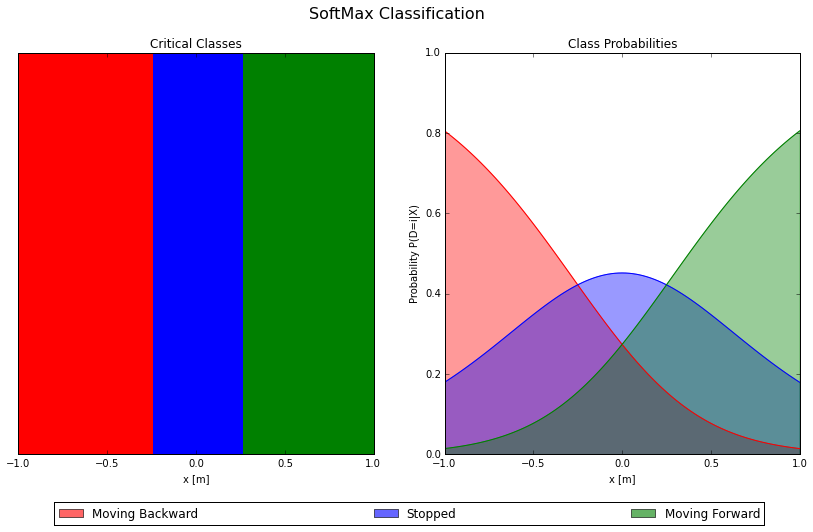

In [19]:
labels = ['Moving Backward', 'Stopped', 'Moving Forward']
sm = SoftMax(weights=np.array([[-2], [0], [2],]),
             biases=np.array([-0.5, 0, -0.5]),
             state_spec='x', class_labels=labels,
             bounds=[-1, 0, 1, 1])
sm.plot()

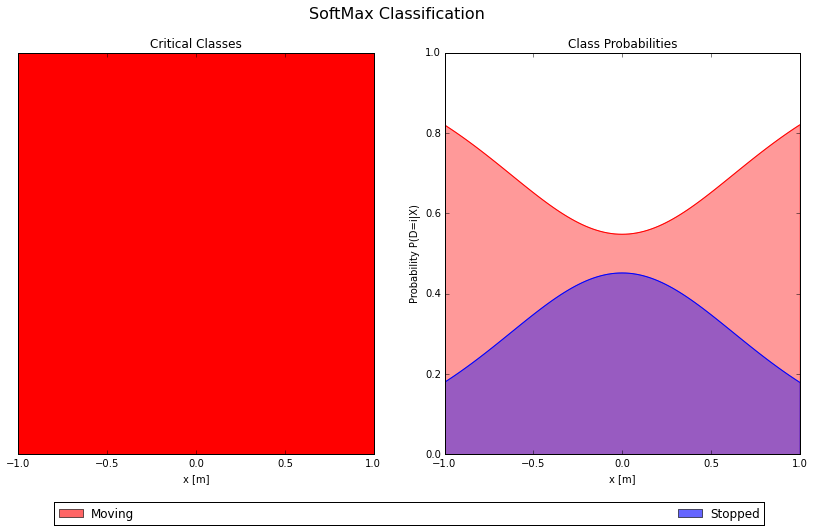

In [34]:
labels = ['Moving', 'Stopped', 'Moving']
sm = SoftMax(weights=np.array([[-2], [0], [2],]),
             biases=np.array([-0.5, 0, -0.5]),
             state_spec='x', class_labels=labels,
             bounds=[-1, 0, 1, 1])
sm.plot()

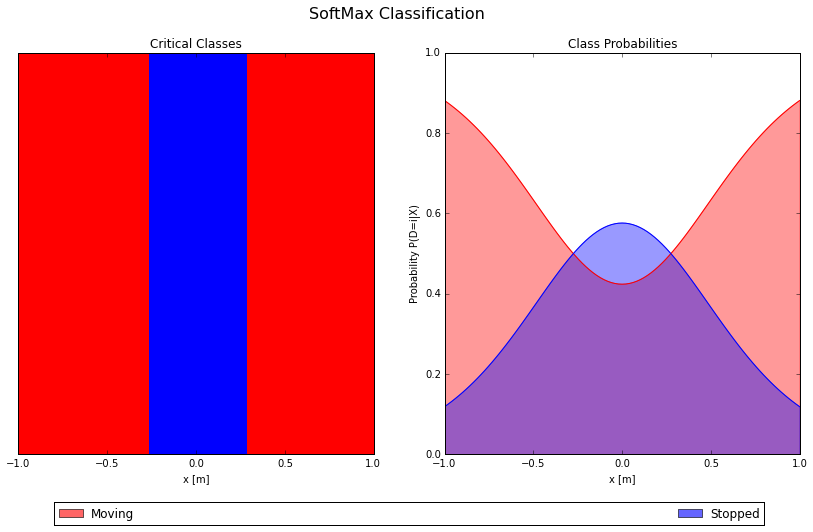

In [31]:
labels = ['Moving', 'Stopped', 'Moving']
sm = SoftMax(weights=np.array([[-3], [0], [3],]),
             biases=np.array([-1, 0, -1]),
             state_spec='x', class_labels=labels,
             bounds=[-1, 0, 1, 1])
sm.plot()

The summing the probabilities of `Moving Backward` and `Moving Forward` into a new `Moving` class has completely changed our class boundaries! `Stopped` still has the exact same probability distribution, but it is dominated by the new `Moving` superclass.

This is an example of the *dependence between class gradient and inter-class boundaries*. That is, when we combine classes to make an MMS distribution, the superclass will either have a new boundary with the other classes, or the gradient of either the superclass or the other classes must change to perserve boundaries.

In the above example, the meanings of the probability distributions remain the same: if we do not discriminate the direction of movement, then the chance the target is moving, given any state $x$, is the same as the sum of both directions. In this sense, there is nothing wrong with our MMS formulation.

However, in the case where we have clearly defined class boundaries, it is important to maintain those boundaries, thus the slope of the distributions must change: we must amend probabilistic meaning to preserve spatial meaning. Let's look at the math to derive this relationship between class gradient and inter-class boundaries.

Take three arbitrary classes `A`, `B`, and `C`. We will sum `A` and `C` together to make superclass `D`:

\begin{align}
P(L=D \vert \mathbf{x}) &= P(L=A \vert \mathbf{x}) + P(L=C \vert \mathbf{x}) \\
&= \frac{e^{\mathbf{w}_A ^T \mathbf{x} + b_A}}{\sum_{k\in {A, B, C}} e^{\mathbf{w}_k^T\mathbf{x} + b_k}}
+ \frac{e^{\mathbf{w}_C^T \mathbf{x} + b_C}}{\sum_{k\in {A, B, C}} e^{\mathbf{w}_k^T\mathbf{x} + b_k}}\\
&= \frac{e^{\mathbf{w}_A ^T \mathbf{x} + b_A} + e^{\mathbf{w}_C^T \mathbf{x} + b_C}}{\sum_{k\in {A, B, C}} e^{\mathbf{w}_k^T\mathbf{x} + b_k}}
\end{align}

Recall that when the classes have equal probability (i.e. at a boundary shared by both classes), the log of the ratio of the class probabilities is zero:

\begin{align}
L_{ln}(B,D) &= 0 =
\ln{\frac{P(L=B \vert \mathbf{x})}{P(L=D \vert \mathbf{x})}} 
= \ln{\frac{e^{\mathbf{w}_B^T \mathbf{x} + b_B}}{e^{\mathbf{w}_A ^T \mathbf{x} + b_A} + e^{\mathbf{w}_C^T \mathbf{x} + b_C}}} \\
&= \mathbf{w}_B^T \mathbf{x} + b_B - \ln{\left( e^{\mathbf{w}_A ^T \mathbf{x} + b_A} + e^{\mathbf{w}_C^T \mathbf{x} + b_C}\right)}
\end{align}

If we want the class boundaries to remain the same between regular and multimodal SoftMax, then we must also have:

$$
L_{ln}(B,A) = 0 = (\mathbf{w}_B - \mathbf{w}_A)^T \mathbf{x} + (b_B - b_A)
$$

and 

$$
L_{ln}(B,C) = 0 = (\mathbf{w}_B - \mathbf{w}_C)^T \mathbf{x} + (b_B - b_C)
$$



Also, recall the ODE for the slope of a SoftMax distribution:

$$
\frac{\partial P(L = i \vert \mathbf{x})} {\partial \mathbf{x}} = 
P(L = i \vert \mathbf{x}) \left(\mathbf{w}_{i} - \sum_{k=1}^M \mathbf{w}_{k}P(L = k \vert \mathbf{x}) \right) \\ 
$$


### Example: T-shape revisited

## Subclassing through convex decomposition

### Example: Camera model

In [1]:
from IPython.core.display import HTML

# Borrowed style from Probabilistic Programming and Bayesian Methods for Hackers
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()